# Scripts and Drafts for Arrow-Debreu Market

In [4]:
using Pkg
Pkg.activate("../")
using Revise
using Random, SparseArrays, LinearAlgebra
using JuMP, MosekTools
using Plots, LaTeXStrings, Printf
import MathOptInterface as MOI

using ExchangeMarket
using DRSOM

include("../tools.jl")
include("../plots.jl")
switch_to_pdf(; bool_use_html=true)

  Activating project at `~/workspace/ExchangeMarket.jl/scripts`


:html

## Test run: when is it hard?

In [5]:
include("./func.jl")
mode = 2

if mode == 1
    Random.seed!(1)
    m = 400
    n = 400
    ρ = 0.5
    # b = rand(n, m)
    b = diagm(ones(n))
    # b ./= sum(b; dims=2)
    e = ones(n)
    f0 = ArrowDebreuMarket(m, n; b=b, ρ=ρ, scale=30.0, sparsity=0.99)
elseif mode == 2
    # symmetric case
    Random.seed!(1)
    m = 50
    n = 50
    ρ = 0.5
    # b = rand(n, m)
    b = diagm(ones(n))
    # b ./= sum(b; dims=2)
    c = sprand(n, n, 0.999) * 30.0
    ExchangeMarket.add_nonzero_entries!(c, m, n, 1.0)
    e = ones(n)
    f0 = ArrowDebreuMarket(m, n; c=c, b=b, ρ=ρ)
else
    Random.seed!(1)
    m = 10
    n = 10
    ρ = -20
    f0 = generate_triagular_market(m, n; ρ=ρ, scale=1.0)
end
linconstr = LinearConstr(1, n, ones(1, n), [1.0])
# -----------------------------------------------------------------------
# compute ground truth
# -----------------------------------------------------------------------
f1 = copy(f0)
p₀ = ones(n) ./ (n)
x₀ = ones(n, m) ./ m
f1.x .= x₀
alg = HessianBar(
    n, m, p₀;
    linconstr=linconstr,
)
alg.linsys = :direct

ArrowDebreuMarket initialization started...
ArrowDebreuMarket initialized in 7.700920104980469e-5 seconds
ArrowDebreuMarket initialization started...
ArrowDebreuMarket initialized in 5.1975250244140625e-5 seconds


:direct

alg.p = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
7th iteration |p|₁: 1.0e+00 sum(q): 2.9e-10
   |-7th               φ: -1.058e+03  η: 5.000e+01
   |-7th         inner_k: 0
   |-7th               p: [1.64e-02, 2.29e-02]
   |-7th               r: 5.5e-19  λ₁: [0.0e+00, 4.6e-02]
   |-7th               α: 6.5e-13 M: 1.8e-12 |v|: 2.1e-09
   |-7th            |z|ₚ: 1.2994e-11
   |-7th              αₘ: 1.0e+00


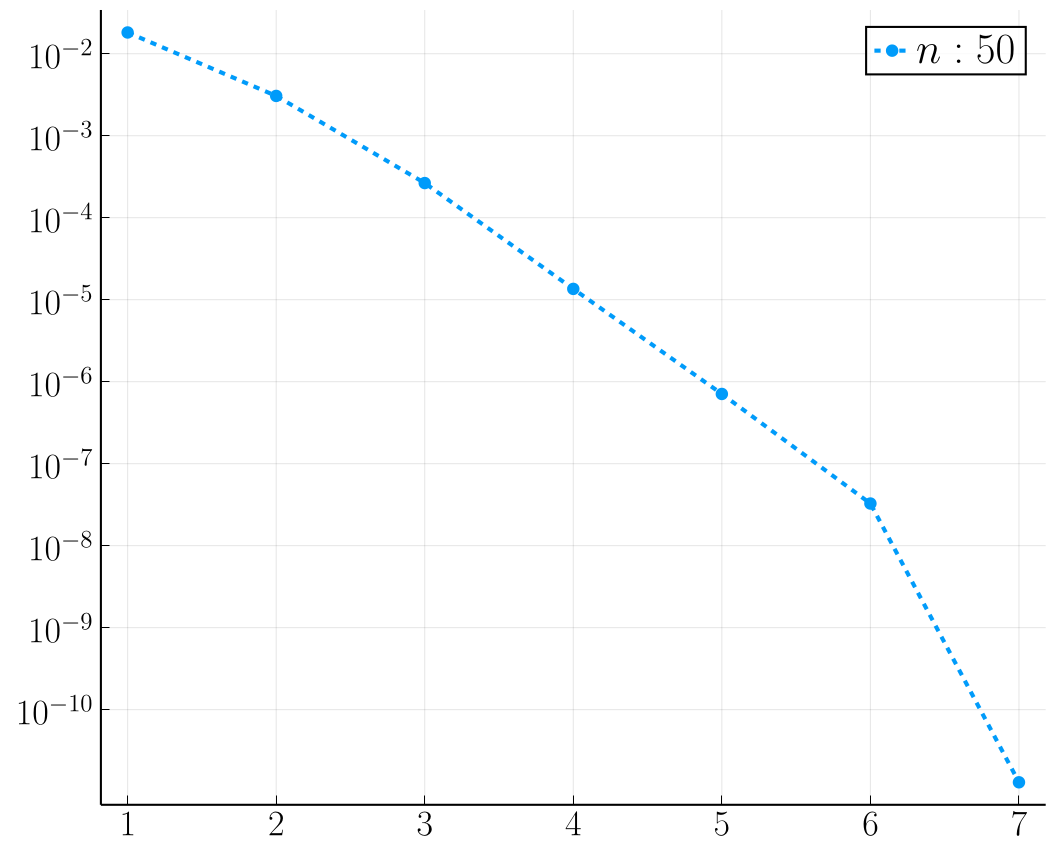

In [6]:
traj_p, traj_beta, traj_pot, traj_kappa = potred2(
    f1, alg;
    K=200, log_interval=10,
    scaler=1.0,
    η=n,
    ϵ=1e-8
)
fig = generate_empty(; shape=:wide, use_html=false)
plot!(
    fig,
    legend=:topright,                   # place legend on top
    legend_columns=4,                  # two columns
    legendbackgroundcolor=RGBA(1.0, 1.0, 1.0, 0.8),
    # yticks=(-36:1:0) .|> exp,
    xtickfont=font(18),
    ytickfont=font(18),
    yscale=:log,
    size=(700, 600),
)
plot!(fig, (traj_beta.+1e-20)[1:1:end], label=L"n: %$(n)", linewidth=2, linestyle=:dash, markershape=:circle, markerstrokecolor=nothing, markerstrokewidth=0.0)
# savefig(fig, "/tmp/arrow_beta_$(n).pdf")
fig

In [4]:
idx = alg.∇ .|> abs |> argmax
[alg.p[idx] alg.∇[idx]]

1×2 Matrix{Float64}:
 0.0260507  4.62925e-9

In [5]:
idx = alg.p .> 1e-3
[alg.p[idx] alg.∇[idx]]
# [alg.p alg.∇]

50×2 Matrix{Float64}:
 0.015965   -1.24957e-9
 0.0184217  -1.08264e-9
 0.0220712   3.05262e-10
 0.0200357  -7.25465e-10
 0.023783    1.69599e-9
 0.0194166  -9.31951e-10
 0.0205568  -7.84044e-10
 0.022394    6.7614e-10
 0.0199056  -7.82448e-10
 0.0217196  -1.14639e-10
 ⋮          
 0.0206369  -3.01501e-10
 0.0187296  -8.88227e-10
 0.0244403   2.64259e-9
 0.0198365  -9.09755e-10
 0.0196932  -9.82151e-10
 0.0209303  -5.11452e-10
 0.0206399  -4.95442e-10
 0.0183774  -1.17684e-9
 0.0202002  -4.927e-10

In [ ]:
irange = [-12:0.0001:-11...]
zrange = []
for i in irange
    alg.p[2:end-1] .= 10^i
    play!(alg, f1)
    grad!(alg, f1)
    eval!(alg, f1)
    push!(zrange, abs.(alg.∇[2]))
end
fig = generate_empty(; shape=:square, settick=false)
plot!(
    fig, 10.0 .^ irange, zrange, label="", linewidth=4,
    marker=nothing,
    markershape=:circle, markerstrokecolor=nothing, markerstrokewidth=0.0,
    xscale=:log10, yscale=:log10,
    ylabel=L"|z^{(2)}(\mathbf p)|",
    xlabel=L"p^{(2)}",
    labelfontsize=20,
    xtickfont=font(20),
    ytickfont=font(20),
    legendfontsize=20,
    titlefontsize=20,
    size=(500, 400)
)
savefig(fig, "/tmp/arrow_near_leontief_$(n).pdf")
irange[argmin(zrange)]

In [ ]:
zrange

In [ ]:
# for -20, −6.6227015
alg.p[2:n-1] .= 10^(-11.138129999)
play!(alg, f1)
grad!(alg, f1)
eval!(alg, f1)
alg.∇

In [ ]:
alg.p

## Plots by $\rho$

In [ ]:
results = []
n = m = 200
ρs = [-80, -40, -20, -10, -1, 0.95]
for ρ in ρs
    b = diagm(ones(n))
    e = ones(n)

    # -----------------------------------------------------------------------
    # setup market
    # -----------------------------------------------------------------------
    f0 = ArrowDebreuMarket(m, n; b=b, ρ=ρ, scale=30.0, sparsity=0.99)
    linconstr = LinearConstr(1, n, ones(1, n), [1.0])

    # -----------------------------------------------------------------------
    # compute ground truth
    # -----------------------------------------------------------------------
    f1 = copy(f0)
    p₀ = ones(n) ./ (n)
    x₀ = ones(n, m) ./ m
    f1.x .= x₀
    alg = HessianBar(
        n, m, p₀;
        linconstr=linconstr,
    )
    alg.linsys = :direct
    traj_p, traj_beta, traj_residual, traj_kappa = potred(
        f1, alg; log_interval=50, K=5000,
        scaler=1.0,
        η=1e3
        # η=√n * 1e-3
    )
    push!(results, [traj_p, traj_beta, traj_residual, traj_kappa])
end
colors = [
    "#000000",  # black
    "#08306b",  # very dark blue
    "#08519c",  # dark blue
    "#2171b5",  # medium-dark blue
    "#4292c6",  # medium blue
    "#6baed6",  # medium-light blue
    "#9ecae1",  # light blue
    "#c6dbef",  # soft blue
    "#dbe9f6"   # pale but still visible
]
fig_beta = generate_empty(; shape=:wide)
plot!(
    fig_beta,
    legend=:topright,                   # place legend on top
    legend_columns=4,                  # two columns
    legendbackgroundcolor=RGBA(1.0, 1.0, 1.0, 0.8),
    yticks=10.0 .^ (-36:4:3),
    xtickfont=font(18),
    ytickfont=font(18),
    # xscale=:log10,
    size=(700, 600),
)
for (idx, (traj_p, traj_beta, traj_pot, traj_kappa)) in enumerate(results)
    _ρ = ρs[idx]
    plot!(fig_beta, traj_beta .+ 1e-20, label=L"r: %$(_ρ)", linewidth=2, linestyle=:dash, markershape=:circle, color=colors[idx], markerstrokecolor=nothing, markerstrokewidth=0.0)
end
savefig(fig_beta, "/tmp/arrow_beta.pdf")


## Plots by $n$

In [ ]:
results = []
# m = 1000
ns = [800, 400, 200, 100]
ρ = -100
Random.seed!(1)
for n in ns
    # Random.seed!(1)
    m = n
    # b = rand(n, m)
    # b ./= sum(b; dims=2)
    b = diagm(ones(n))
    e = ones(n)
    Π = I - e * e' / n

    # -----------------------------------------------------------------------
    # setup market
    # -----------------------------------------------------------------------
    f0 = ArrowDebreuMarket(m, n; b=b, ρ=ρ, scale=30.0, sparsity=0.9)
    linconstr = LinearConstr(1, n, ones(1, n), [1.0])

    # -----------------------------------------------------------------------
    # compute ground truth
    # -----------------------------------------------------------------------
    f1 = copy(f0)
    p₀ = ones(n) ./ (n)
    x₀ = ones(n, m) ./ m
    f1.x .= x₀
    alg = HessianBar(
        n, m, p₀;
        linconstr=linconstr,
    )
    alg.linsys = :direct
    traj_p, traj_beta, traj_pot, traj_kappa = potred(
        f1, alg; log_interval=50, K=5000,
        scaler=10,
        η=√n * 1e-3
    )
    push!(results, [traj_p, traj_beta, traj_pot, traj_kappa])
end


### Plot beta

In [ ]:
colors = [
    "#000000",  # black
    "#08306b",  # very dark blue
    "#08519c",  # dark blue
    "#2171b5",  # medium-dark blue
    "#4292c6",  # medium blue
    "#6baed6",  # medium-light blue
    "#9ecae1",  # light blue
    "#c6dbef",  # soft blue
    "#dbe9f6"   # pale but still visible
]
fig_beta = generate_empty(; shape=:wide)
plot!(
    fig_beta,
    legend=:topright,                   # place legend on top
    legend_columns=4,                  # two columns
    legendbackgroundcolor=RGBA(1.0, 1.0, 1.0, 0.8),
    yticks=10.0 .^ (-36:4:3),
    xtickfont=font(18),
    ytickfont=font(18),
    # xscale=:log10,
    size=(700, 600),
)
for (idx, (traj_p, traj_beta, traj_residual, traj_kappa)) in enumerate(results)
    _n = ns[idx]
    _l = length(traj_beta)
    _y = (traj_beta .+ 1e-20) .* _n
    println("$(_n)th iteration: $(traj_beta[end])")
    if _l > 1000
        plot!(fig_beta, 1:20:_l, _y[1:20:end], label=L"n: %$(_n)", linewidth=2, linestyle=:dash, markershape=:circle, color=colors[idx], markerstrokecolor=nothing, markerstrokewidth=0.0)
    else
        plot!(fig_beta, _y, label=L"n: %$(_n)", linewidth=2, linestyle=:dash, markershape=:circle, color=colors[idx], markerstrokecolor=nothing, markerstrokewidth=0.0)
    end
end
savefig(fig_beta, "/tmp/arrow_beta_n_$ρ.pdf")

### Plot c and kappa

In [ ]:
ffs = []

fig_kappa = plot(
    labelfontsize=20,
    xtickfont=font(16),
    ytickfont=font(16),
    legendfontsize=20,
    titlefontsize=20,
    legend=:topright,
    legendfonthalign=:left,
    linewidth=2,
)
plot!(
    fig_kappa,
    legend=:topright,                   # place legend on top
    legend_columns=4,                  # two columns
    legendbackgroundcolor=RGBA(1.0, 1.0, 1.0, 0.8),
    # yticks=10.0 .^ (-36:4:3),
    xtickfont=font(18),
    ytickfont=font(18),
    # xscale=:log10,
    size=(700, 600),
)

for (idx, (traj_p, traj_beta, traj_residual, traj_c, traj_kappa)) in enumerate(results)
    _n = ns[idx]
    plot!(fig_kappa, traj_kappa[1:end-1], label=L"n: %$(_n)", linewidth=2, linestyle=:dash, markershape=:circle, color=colors[idx], markerstrokecolor=nothing, markerstrokewidth=0.0)
    _l = length(traj_kappa)
    # plot!(fig_kappa, traj_kappa[max(1, _l - 100):end], label=L"\rho: %$(_n)", linewidth=2, linestyle=:dash, markershape=:circle, color=colors[idx], markerstrokecolor=nothing, markerstrokewidth=0.0)
end
push!(ffs, fig_kappa)
savefig(fig_kappa, "/tmp/arrow_kappa_n.pdf")


In [ ]:
### focus on n=50
fig_kappa = plot(
    labelfontsize=20,
    xtickfont=font(16),
    ytickfont=font(16),
    legendfontsize=20,
    titlefontsize=20,
    legend=:topright,
    legendfonthalign=:left,
    linewidth=2,
)
plot!(
    fig_kappa,
    legend=:topright,                   # place legend on top
    legend_columns=4,                  # two columns
    legendbackgroundcolor=RGBA(1.0, 1.0, 1.0, 0.8),
    # yticks=10.0 .^ (-36:4:3),
    xtickfont=font(18),
    ytickfont=font(18),
    # xscale=:log10,
    size=(700, 600),
)
_n = ns[4]
plot!(fig_kappa, results[4][end][end-100:end-1], label=L"n: %$(_n)", linewidth=2, linestyle=:dash, markershape=:circle, markerstrokecolor=nothing, markerstrokewidth=0.0)
savefig(fig_kappa, "/tmp/arrow_kappa_$(_n).pdf")


### Plot c

In [ ]:
fig_c = generate_empty(; shape=:wide)
plot!(
    fig_c,
    legend=:topright,                   # place legend on top
    legend_columns=4,                  # two columns
    legendbackgroundcolor=RGBA(1.0, 1.0, 1.0, 0.8),
    # yticks=10.0 .^ (-36:4:3),
    xtickfont=font(18),
    ytickfont=font(18),
    # xscale=:log10,
    size=(700, 600),
)

for (idx, (traj_p, traj_beta, traj_residual, traj_c, traj_kappa)) in enumerate(results)
    _n = ns[idx]
    plot!(fig_c, traj_c[1:end-1], label=L"n: %$(_n)", linewidth=2, linestyle=:dash, markershape=:circle, color=colors[idx], markerstrokecolor=nothing, markerstrokewidth=0.0)
end
savefig(fig_c, "/tmp/arrow_c_n.pdf")

# The Leontief structure / extremes

In [ ]:
include("./func.jl")
mode = 3
results = []

for ρ in [-0.95, -5]
    for n in [3, 10, 20, 50]
        f0 = generate_triagular_market(n, n; ρ=ρ, scale=1.0)

        linconstr = LinearConstr(1, n, ones(1, n), [1.0])
        # -----------------------------------------------------------------------
        # compute ground truth
        # -----------------------------------------------------------------------
        f1 = copy(f0)
        p₀ = ones(n) ./ (n)
        x₀ = ones(n, n) ./ n
        f1.x .= x₀
        alg = HessianBar(
            n, n, p₀;
            linconstr=linconstr,
        )
        alg.linsys = :direct
        traj_p, traj_beta, traj_pot, traj_kappa = potred(
            f1, alg;
            K=1000, log_interval=10,
            scaler=1.0,
            η=1e2,
            ϵ=1e-15
        )
        # fig = generate_empty(; shape=:wide)
        # plot!(
        #     fig,
        #     legend=:topright,                   # place legend on top
        #     legend_columns=4,                  # two columns
        #     legendbackgroundcolor=RGBA(1.0, 1.0, 1.0, 0.8),
        #     # yticks=(-36:1:0) .|> exp,
        #     xtickfont=font(18),
        #     ytickfont=font(18),
        #     yscale=:log,
        #     size=(700, 600),
        # )
        # plot!(fig, (traj_beta.+1e-20)[1:1:end], label=L"n: %$(n)", linewidth=2, linestyle=:dash, markershape=:circle, markerstrokecolor=nothing, markerstrokewidth=0.0)
        # savefig(fig, "/tmp/arrow_beta_$(n).pdf")

        # fig = generate_empty(; shape=:wide, settick=false)
        # plot!(
        #     fig,
        #     legend=:topright,                   # place legend on top
        #     legend_columns=4,                  # two columns
        #     legendbackgroundcolor=RGBA(1.0, 1.0, 1.0, 0.8),
        #     xtickfont=font(18),
        #     ytickfont=font(18),
        #     # yscale=:log,
        #     size=(700, 600),
        # )
        # # plot!(fig, traj_pot[1:1:end] .- minimum(traj_pot), label=L"n: %$(n)", linewidth=2, linestyle=:dash, markershape=:circle, markerstrokecolor=nothing, markerstrokewidth=0.0)
        # plot!(fig, traj_pot[1:1:end], label=L"n: %$(n)", linewidth=2, linestyle=:dash, markershape=:circle, markerstrokecolor=nothing, markerstrokewidth=0.0)
        # savefig(fig, "/tmp/arrow_pot_$(n).pdf")
        push!(results, [ρ, n, minimum(alg.p)])
    end
end

In [ ]:
using DataFrames
hcat([results...])'

